<center><img src="https://github.com/insaid2018/Term-1/blob/master/Images/INSAID_Full%20Logo.png?raw=true" width="360" height="160" /></center>

# <center>**Vehicle Detection**</center>

## **Table of Contents**

1. [**Problem Statement**](#Section1)<br>
2. [**Importing Libraries**](#Section2)<br>
3. [**Loading Data**](#Section3)<br>
4. [**Description of the Dataset**](#Section4)<br>
5. [**Data Pre-processing**](#Section5)<br>
6. [**Model Buiding**](#Section6)<br>
7. [**Prediction on Test Set**](#Section7)<br>
8. [**Conclusion**](#Section8)<br>

---
<a name=Section1></a>
# **1. Problem Statement**
---

 
- Mumbai-based AI company that is currently focussing on the **object detection** through technologies such as ML and AI has to come up with an **open door project**.
 
- Here, the goal of this project is to detect the presence of a vehicle in the given image.
- All the data scientists and the ML engineers are very excited about this challenge 
- As compensation, someone who comes up with the best solution will be **rewarded** with a cash prize of $1M.

<center><img src="https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/new-cars-2022-1631371525.jpg?crop=0.9863636363636363xw:1xh;center,top&resize=980:*" height= 450 width= 800 ></center>

 	
## **Scenario:**

- You are one of the data scientists to whom everyone is looking forward to. Your objective here would be to come up with an accurate **ML & AI system** that can tell the presence of vehicle in a image.

- The vehicle of an image is **manually** identified from images in order to write any blog or post on it.

- This process is very **slow**, **time-consuming**, and **labour-intensive**.

- In order to do so, you’ll have to read and study the dataset properly.







<a name=Section2></a>

---
# **2. Importing Libraries**
---

In [54]:
# importing data analysis and plotting libraries
import  pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# train test split
from sklearn.model_selection import train_test_split

# importing tensorflow-keras and layers ans callbacks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization,MaxPool2D,Dense,Conv2D,Flatten
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler

# for removing warnings
import warnings
warnings.filterwarnings('ignore')

# importing python image library
from PIL import Image
from tqdm import tqdm
import os

# metrics
from sklearn.metrics import accuracy_score

---
<a name=Section3></a>
# **3. Loading Data**
---

- Mounting Google Drive onto colab notebook to load the data file.
  
  - This will help us to load **large dataset** with ease.

- You can also load the data file via upload option on the **left side** of the colab notebook.

- If you have the data in your **local system** and you are working on your local system then you can load the file using its **file location**.

- Most of the time large dataset comes in a **zip format**, so before working on the data we need to first **unzip the data**.

- After unzipping the folder you can access the actual dataset folders.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unrar x "/content/drive/MyDrive/Colab Notebooks/Vehicle detection/train.rar" "/content"

- We are loading the image data using  **keras functions** called `image_dataset_from_directory`.

- This will help us to **extract** the image label from its **folder name**.

- We are specifying the **batch_size** as **32** and **height** and **width** of an image as **180**.

In [5]:
batch_size = 32
img_height = 180
img_width = 180

train_dir = '/content/train'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14220 files belonging to 2 classes.
Using 11376 files for training.
Found 14220 files belonging to 2 classes.
Using 2844 files for validation.


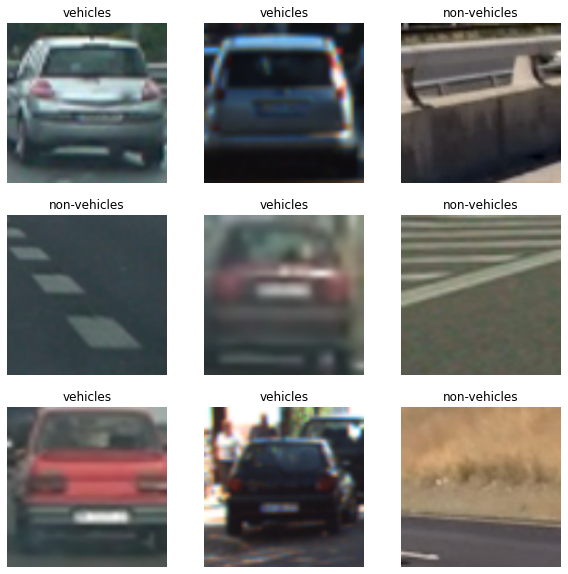

In [6]:
# showing different images from both typs of labels
class_names = ['non-vehicles','vehicles']
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

<a name=Section4></a>

---
# **4. Data Description**
---


- There are **2 sub-folders**, each belonging to a scene.

- Each scene sub-folder contains images belonging to that scene.

- The dataset contains the images of the following  scenes:
  - **Vehicles**: This class contains images of vehicles.
  - **Non-vehicles**: This class contains images of non-vehicles.

<a name=Section5></a>

---
# **5. Data Preprocessing**
---

### Data Augmentation

- We are doing data augmentation by randomly **flipping**, **rotating** and **zooming** the image.

- This **increase** the **diversity** of data available for training models, without actually collecting new data

In [7]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

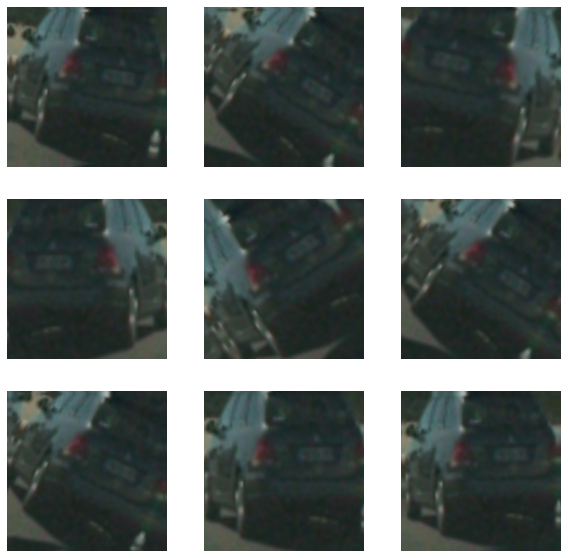

In [8]:
# showing images after data augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


- We will standardize our image input data.
- The below code is to **rescale** an input in the **[0, 255]** range to  **[0, 1]** range, by passing **scale = 1./255**.

In [9]:
# normalising and rescaling of images
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

<a name=Section6></a>

---
# **6. Model Building**
---

### Build the Model

- Let's build our model.

- Here, we'll use a `Sequential` model with dense layer and other layers such as;        
   - data_augmentation layer to **add more information** without adding extra data.

   - Rescaling layer to **rescale** the input to **[0, 1]** range.

In [23]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.BatchNormalization(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation= 'relu'),
  layers.Dense(1,activation='sigmoid')
])

In [24]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [25]:
# function for learning rate
def schedule(epoch,lr):
    if epoch>=5:
        return 0.0001
    return 0.001
    
early_stop=EarlyStopping(monitor='val_accuracy',patience=3)
learning_rate_scheduler=LearningRateScheduler(schedule)

In [26]:
epochs=9
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs) # training our model

Epoch 1/9
356/356 [==============================] - 58s 159ms/step - loss: 0.2268 - accuracy: 0.9103 - val_loss: 0.4749 - val_accuracy: 0.8326
Epoch 2/9
356/356 [==============================] - 56s 158ms/step - loss: 0.1001 - accuracy: 0.9632 - val_loss: 0.1076 - val_accuracy: 0.9708
Epoch 3/9
356/356 [==============================] - 56s 157ms/step - loss: 0.0793 - accuracy: 0.9709 - val_loss: 0.3518 - val_accuracy: 0.9153
Epoch 4/9
356/356 [==============================] - 56s 157ms/step - loss: 0.0530 - accuracy: 0.9815 - val_loss: 0.0493 - val_accuracy: 0.9817
Epoch 5/9
356/356 [==============================] - 56s 158ms/step - loss: 0.0608 - accuracy: 0.9786 - val_loss: 0.0482 - val_accuracy: 0.9856
Epoch 6/9
356/356 [==============================] - 56s 158ms/step - loss: 0.0596 - accuracy: 0.9791 - val_loss: 0.0686 - val_accuracy: 0.9778
Epoch 7/9
356/356 [==============================] - 56s 158ms/step - loss: 0.0490 - accuracy: 0.9820 - val_loss: 0.0457 - val_accuracy:

Plotting train vs val accuracy and loss plots


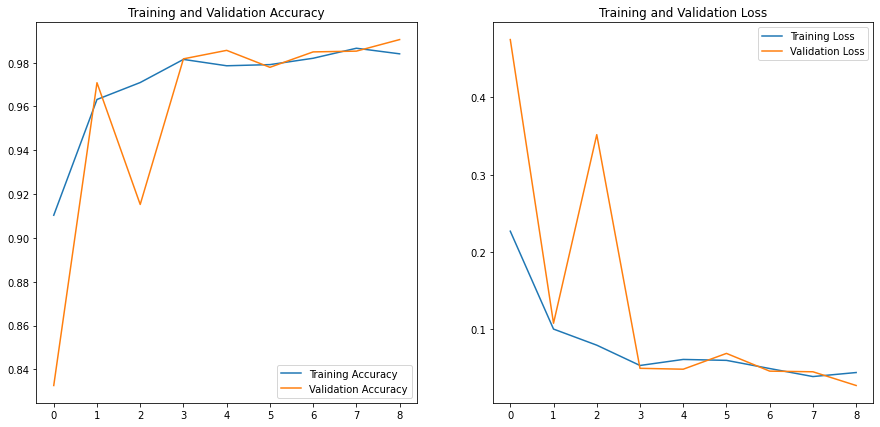

In [27]:
# plots of train vs validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observation**
- With respect to accuracy in both in train and val we can see there is incresing tendency with epochs and achievd **val accuracy** of **99 %**

- With respect to loss in both in train and val we can see there is decreasing tendency with epochs and achievd **val loss** of **0.02**


<a name=Section7></a>
## 7. Prediction on test set

In [ ]:
!unrar x "/content/drive/MyDrive/Colab Notebooks/Vehicle detection/test.rar" "/content" # extracting our test data

- The below code is used to get all the locations and names of images and store it in a list `x_test`.

In [29]:
x_test=[]
directory = r'/content/test'
for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        test_data= os.path.join(directory, filename)
        x_test.append(test_data)
    else:
        continue

- The above **created list** of images is then looped and we predict the respective labels using the following code.

- The prediction is stored in a **dictionary** with the file location  containing the name of the image.

In [30]:
# predicting test images using our trained model
submission_file={}
for i in x_test:
  file = i
  img = tf.keras.preprocessing.image.load_img(
  i, target_size=(img_height, img_width))
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  
  predictions = model.predict(img_array)
  y_pred=class_names[1 if predictions[0] > 0.5 else 0]
  submission_file[i]= y_pred

- Here we are converting the **dictionary to dataframe** and renaming the columns.

In [32]:
# creating datafrme
your_df_from_dict=pd.DataFrame.from_dict(submission_file,orient='index')
your_df_from_dict=your_df_from_dict.reset_index()
subm = your_df_from_dict.rename(columns={'index': 'Image_Name', 0: 'Labels'})
label=subm['Labels']

- The below code will **extract** only the image name with its extension from the image location using python **regular expression** library.

In [33]:
import re
lis=[]
for j in subm['Image_Name']:
    data=re.findall(r'[^\/]+(?=)',j)[-1]
    lis.append(data)
df = pd.DataFrame(lis, columns = ['Image_Name']) 
frames = [df,label]
result = pd.concat(frames,axis=1)

In [35]:
# our submission file
result.to_csv('submission.csv',header=False,index=False)

In [62]:
sub= pd.read_csv('submission.csv',names=['Image_Name', 'Labels'] )

In [65]:
# replacing labels with 0 and 1's
sub['Labels']= np.where(sub['Labels']== 'non-vehicles',0,1)

In [81]:
# getting original labels
y_df = pd.read_csv('y_test.csv', names=['Image_Name', 'Labels'])
y_df.head()

,Image_Name,Labels
0,extra931,non-vehicle
1,extra250,non-vehicle
2,1664,vehicle
3,952,vehicle
4,2080,vehicle


In [82]:
# replacing labels with 0 and 1's
y_df['Labels']= np.where(y_df['Labels']== 'vehicle',1,0)

In [84]:
print('Accuracy score for test data is:',accuracy_score(y_df['Labels'], sub['Labels'] ))

Accuracy score for test data is: 0.9954802259887006


<a name=Section8></a>
## 8. Conclusion

- We studied **in-depth** about the various **features** from the images.
- We used **data augmentation** to create more sample images for our model.
- We used **EarlyStopping** to prevent model fom overfitting.
- This model could also implement using **Transfer learning**.
- With simple model building we achieved test accuracy of **99.5 %** .